This notebook wrapps the MQRNN modules. It includes some explaining about added features, training the model, and evaluation (loss + graphs) on training set. If you don't wish to train the model, toggle the train boolean on the next cell, and a pretrained model will be loaded.

In [ ]:
train = True

In [17]:
%pylab inline
plt.style.use("bmh")
import pandas as pd
import numpy as np
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt 
import torch
from torch import optim, device, cuda
import random

from training import Estimator, retrieve_data
from Models import MQRNN
from plot_utils import plot_forecast, move_axes

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## The model features - 9 calendar features

The night / day cycle varies between summer and winter (see graph below that illustrates that).

In the summer and winter, the daily cycle is changing.

Therefore add just a daily cycle and yearly cycle features are not enough to identify whole annual cycles.

For example, while in the summer the consumption peak is in the afternoon and winter probably in the evening. Also, the difference between maximum and minimum  daily consumption is varying throughout the year.
The following variables together try to predict the full yearly sub-cycles.

**Full calendar features ($x_h,x_f$):**
1. yearly_cycle = np.sin(2 * np.pi * df.index.dayofyear / 366)

2. weekly_cycle = np.sin(2 * np.pi * df.index.dayofweek / 7)

3. daily_cycle = np.sin(2 * np.pi * df.index.hour / 24)

4. weekend = (df.index.dayofweek < 5).astype(float)

5. night = ((df.index.hour < 7) & (df.index.hour > 21)).astype(float)

6. winter = ((df.index.month < 4) & (df.index.month > 10)).astype(float)

7. Holiday = ((df.index.is_year_end | df.index.is_year_start) | (( df.index.month==12) & (df.index.daysinmonth==25))).astype(float)

8. winter_daily_cycle = daily_cycle * winter

9. summer_daily_cycle = daily_cycle * (1 - winter)


`calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle", "weekend", "night", "winter", "Holiday", "summer_daily_cycle", "winter_daily_cycle"]`


It should be noted that adding all nine features improves prediction accuracy mainly when using a small sample. However, when the models are heavily trained and include 100 samples (per househould) or more, these features contribution is minor. 

In [18]:
input_size = 1  # y
embed_size = 9  # x
hidden_size = 30  # for lstm: "both with a state dimension of 30"
context_size = 8  # for c_t/c_a
horizon = 24
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]
samples = 100
batch_size = 32
epochs = 20
print_every = 50

In [19]:
DATA_DIR = pathlib.Path("data")
MODEL_DIR = pathlib.Path("models")
GRAPH_DIR = pathlib.Path("graphs")

MODEL_DIR.mkdir(exist_ok=True)
GRAPH_DIR.mkdir(exist_ok=True)

### Model with all 9 calendar_features

In [ ]:
# Load and init all data and model objects
train_loader, val_loader, test_loader = retrieve_data(samples=samples, batch_size=batch_size)
model = MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles)
estimator = Estimator(batch_size=batch_size, quantiles=quantiles)

In [20]:
# Init training modules and run training
if train:
    optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=4, factor=0.1, verbose=True)
    estimator.train(model, train_loader, val_loader, optimizer, scheduler, epochs=epochs)

2021-03-10 04:39:36.024771 Starting epoch 1 / 20
2021-03-10 04:40:39.705742 t = 50, loss = 0.0608
2021-03-10 04:41:31.359176 t = 100, loss = 0.0624
2021-03-10 04:42:19.961698 t = 150, loss = 0.0427
2021-03-10 04:43:09.118812 t = 200, loss = 0.0445
2021-03-10 04:43:55.826347 t = 250, loss = 0.0359
2021-03-10 04:44:45.249491 t = 300, loss = 0.0363
2021-03-10 04:45:30.788763 t = 350, loss = 0.0509
2021-03-10 04:46:21.433184 t = 400, loss = 0.0343
2021-03-10 04:47:07.817649 t = 450, loss = 0.0397
2021-03-10 04:47:57.362331 t = 500, loss = 0.0306
2021-03-10 04:48:45.513190 t = 550, loss = 0.0352
2021-03-10 04:49:37.051819 t = 600, loss = 0.0356
2021-03-10 04:50:24.192446 t = 650, loss = 0.0375
2021-03-10 04:51:09.628694 t = 700, loss = 0.0406
2021-03-10 04:51:54.977921 t = 750, loss = 0.0336
2021-03-10 04:52:45.267262 t = 800, loss = 0.0375
2021-03-10 04:56:32.973618 Got average loss of (0.04) last_lr = 0.01
2021-03-10 04:56:32.999835 Starting epoch 2 / 20
2021-03-10 04:57:34.118057 t = 50,

2021-03-10 07:10:35.574096 t = 50, loss = 0.0263
2021-03-10 07:11:23.436888 t = 100, loss = 0.0376
2021-03-10 07:12:08.511086 t = 150, loss = 0.0349
2021-03-10 07:12:56.014796 t = 200, loss = 0.0378
2021-03-10 07:13:46.247124 t = 250, loss = 0.0286
2021-03-10 07:14:31.913424 t = 300, loss = 0.0361
2021-03-10 07:15:17.371677 t = 350, loss = 0.0348
2021-03-10 07:16:02.556870 t = 400, loss = 0.0383
2021-03-10 07:16:53.531363 t = 450, loss = 0.0265
2021-03-10 07:17:41.721234 t = 500, loss = 0.0431
2021-03-10 07:18:26.156253 t = 550, loss = 0.0299
2021-03-10 07:19:12.895300 t = 600, loss = 0.0398
2021-03-10 07:19:59.282765 t = 650, loss = 0.0288
2021-03-10 07:20:44.914054 t = 700, loss = 0.0305
2021-03-10 07:21:32.765848 t = 750, loss = 0.0267
2021-03-10 07:22:18.939260 t = 800, loss = 0.0321
2021-03-10 07:26:02.223126 Got average loss of (0.03) last_lr = 0.01
2021-03-10 07:26:02.225127 Starting epoch 11 / 20
2021-03-10 07:27:04.213107 t = 50, loss = 0.0230
2021-03-10 07:27:54.388424 t = 10

2021-03-10 09:37:51.075659 Got average loss of (0.03) last_lr = 0.001
2021-03-10 09:37:51.077659 Starting epoch 19 / 20
2021-03-10 09:38:51.248756 t = 50, loss = 0.0324
2021-03-10 09:39:36.695006 t = 100, loss = 0.0247
2021-03-10 09:40:23.952663 t = 150, loss = 0.0327
2021-03-10 09:41:11.574409 t = 200, loss = 0.0256
2021-03-10 09:42:00.269386 t = 250, loss = 0.0366
2021-03-10 09:42:49.438479 t = 300, loss = 0.0299
2021-03-10 09:43:34.054540 t = 350, loss = 0.0345
2021-03-10 09:44:18.810752 t = 400, loss = 0.0294
2021-03-10 09:45:09.915277 t = 450, loss = 0.0458
2021-03-10 09:45:58.790299 t = 500, loss = 0.0280
2021-03-10 09:46:44.548620 t = 550, loss = 0.0343
2021-03-10 09:47:32.954535 t = 600, loss = 0.0353
2021-03-10 09:48:18.144240 t = 650, loss = 0.0291
2021-03-10 09:49:08.747652 t = 700, loss = 0.0272
2021-03-10 09:49:53.400726 t = 750, loss = 0.0332
2021-03-10 09:50:37.090093 t = 800, loss = 0.0312
2021-03-10 09:54:18.584562 Got average loss of (0.03) last_lr = 0.001
2021-03-10 

Evaluate only: 
If you don't wish to train the model (and set train=False), a pretrained model is loaded for forcasting.

In [22]:
if not train:
    model.load_state_dict(torch.load('models\example'))
model.eval()

MQRNN(
  (encoder): Encoder(
    (lstm): LSTM(10, 30, batch_first=True)
  )
  (decoder): Decoder(
    (global_mlp): Linear(in_features=246, out_features=200, bias=True)
    (local_mlp): Linear(in_features=25, out_features=5, bias=True)
  )
)

In [21]:
loss = 0
for t, (enc_data, dec_data) in enumerate(test_loader):
  loss += estimator.calculate_loss(model, enc_data, dec_data).item()
loss = loss / (t+1)
print("\n","The test average loss:", round(loss, 4))


 The test average loss: 0.028


In [23]:
dataiter = iter(test_loader)
enc_data, dec_data = dataiter.next()
axes = estimator.forcast(model, enc_data, dec_data, input_size=1, plot=True)

The following cell can be run multiple times to observe different foreca

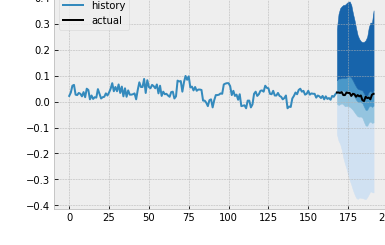

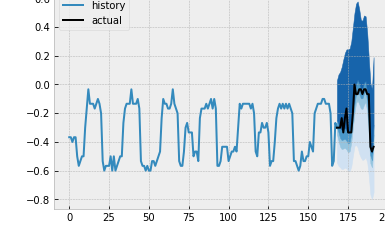

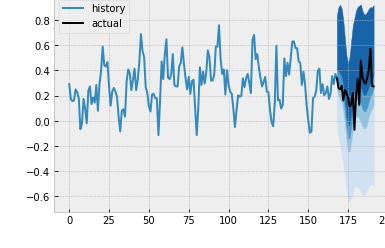

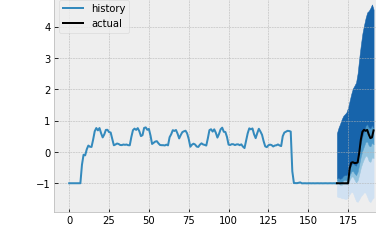

In [26]:
samples = random.sample(range(0, 32), 4)
for i in range(4):
    fig = plt.figure(figsize=(15,8))
    move_axes(axes[samples[i]], fig, 111)
    plt.show()

## The average consumption across all 370 households - a graphical summary

note: the average does not include zeros only

In [ ]:
eldata = pd.read_csv('data\LD2011_2014.txt',
                 parse_dates=[0],
                 delimiter=";",
                 decimal=",")
eldata.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)

eldata=eldata.resample('H', on='timestamp').mean().reset_index()

el_mean=eldata[eldata!=0].set_index("timestamp").mean(axis=1)


## An illustration of the winter-summer cycles




The following graph shows the average consumption over several years.
The colors are arbitrary, illustrating the summer - winter seasons.



In [ ]:
plt.figure(figsize=(16,8))
el_mean.loc["2011-1-1":"2011-4-19"].plot()
el_mean.loc["2011-4-20":"2011-11-19"].plot()
el_mean.loc["2011-11-20":"2012-4-19"].plot()
el_mean.loc["2012-4-20":"2012-11-19"].plot()

el_mean.loc["2012-11-20":"2013-4-19"].plot()
el_mean.loc["2013-4-20":"2013-11-19"].plot()

el_mean.loc["2013-11-20":"2014-4-19"].plot()
el_mean.loc["2014-4-20":"2014-11-19"].plot()
el_mean.loc["2014-11-20":"2015-1-31"].plot()


plt.tight_layout()

The minimum daily consumption has moderate yearly cycles, and the maximum has high cycles.